In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [158]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [159]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [160]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [161]:
#Folder inside results directory that contains all the MOA dump files for these experiments
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/speedup/final/"
wantedCSVfilename = "speedup-pi-loop-fusion"

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [162]:
def parse_speedup(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,acc,prec,recall'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [163]:
def find_sequential_value_by_index(df, algorithm):
    for data in df:
        if (data['algorithm'] == algorithm):
            return data
    

In [164]:
def find_list_value_by_index(df, algorithm):
    response = []

    for data in df:
        if (data['algorithm'] == algorithm):
            response.append(data)

    return response

In [218]:
df_speedup = {
    'airlines': {
        'sequential': [],
        'loop_fusion': []
    },
    'GMSC': {
        'sequential': [],
        'loop_fusion': []
    },
    'covtypeNorm': {
        'sequential': [],
        'loop_fusion': []
    },
    'elecNormNew': {
        'sequential': [],
        'loop_fusion': []
    }
}

from_to = {
    'LBagMB': 'LBagSequential',
    'ARFMB': 'ARFSequential',
    'OBAdwinMB': 'OBAdwinSequential',
    'OBMB': 'OBSequential',
    'OBASHTMB': 'OBASHTSequential',
    'SRPMB': 'SRPSequential'
}

algorithms = ['LBagMB', 'ARFMB', 'OBAdwinMB', 'OBMB', 'OBASHTMB', 'SRPMB']
dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}

for cpu in list([1, 2, 3, 4]):
    resultsFolder = f"{folderMOADumps}/{str(cpu)}/first"
    csvFile = f"parsed_csvs/{wantedCSVfilename}-{str(cpu)}.csv"
    directory = os.fsencode(resultsFolder)
    header_printed = False

    with open(f"{csvFile}", "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                output.write(f"{parse_speedup(f'{os.fsdecode(directory)}/{filename}')}\n")

    df = load_df(f'{csvFile}')

    for index, row in df[['dataset', 'algorithm', 'cores', 'acc', 'time', 'instances']].iterrows():
        if ("Sequential" in row['algorithm']):
            df_speedup[row['dataset']]['sequential'].append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': 1,
                'eficiency': 1,
                'acc': row['acc']
            })
        else:
            data_sequential = find_sequential_value_by_index(df_speedup[row['dataset']]['sequential'], from_to[row['algorithm']])

            speedup = data_sequential['time'] / row['time']
            eficiency = speedup / row['cores']
            
            df_speedup[row['dataset']]['loop_fusion'].append({
                'dataset': row['dataset'],
                'algorithm': row['algorithm'],
                'cores': row['cores'],
                'time': row['time'],
                'instances': row['instances'],
                'speedup': speedup,
                'eficiency': eficiency,
                'acc': row['acc']
            })

/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24336/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24336/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24336/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_24336/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

In [232]:
def gen_graph_speedup(only_eficiency=False):
    filename = f"pi-rates"
    fig, axs = plt.subplots(2, 2, figsize=(14,9))
    datasets = ['airlines', 'GMSC', 'covtypeNorm', 'elecNormNew']

    for ds in datasets:
        current_df = df_speedup[ds]    
        my_id = datasets.index(ds)

        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax2 = ax.twinx()
        ax.set_title(f'{dsformalname[ds]}')

        for alg in algorithms:
            data_sequential = [find_sequential_value_by_index(current_df['sequential'], from_to[alg])]
            data_parallel = find_list_value_by_index(current_df['loop_fusion'], alg)
            df = pd.DataFrame(data_sequential + data_parallel)

            colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
            labels = df.cores
            x = np.arange(len(labels))
            alg_order = algorithms.index(alg)

            if only_eficiency == False:
                ax.plot(x, pd.to_numeric(df.speedup), f'{colors[alg_order]}--', linewidth=0.75, label=f'{alg}-speedup')
            else:
                ax.plot(x, pd.to_numeric(df.eficiency), f'{colors[alg_order]}--', linewidth=0.75, label=f'{alg}-eficiency')

            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                if only_eficiency == False:
                    ax.set_ylabel('Speedup')
                else:
                    ax.set_ylabel('Eficiency', color = "r")

            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Cores')

            ax.set_xticks(x)
            ax.set_xticklabels(labels)

    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


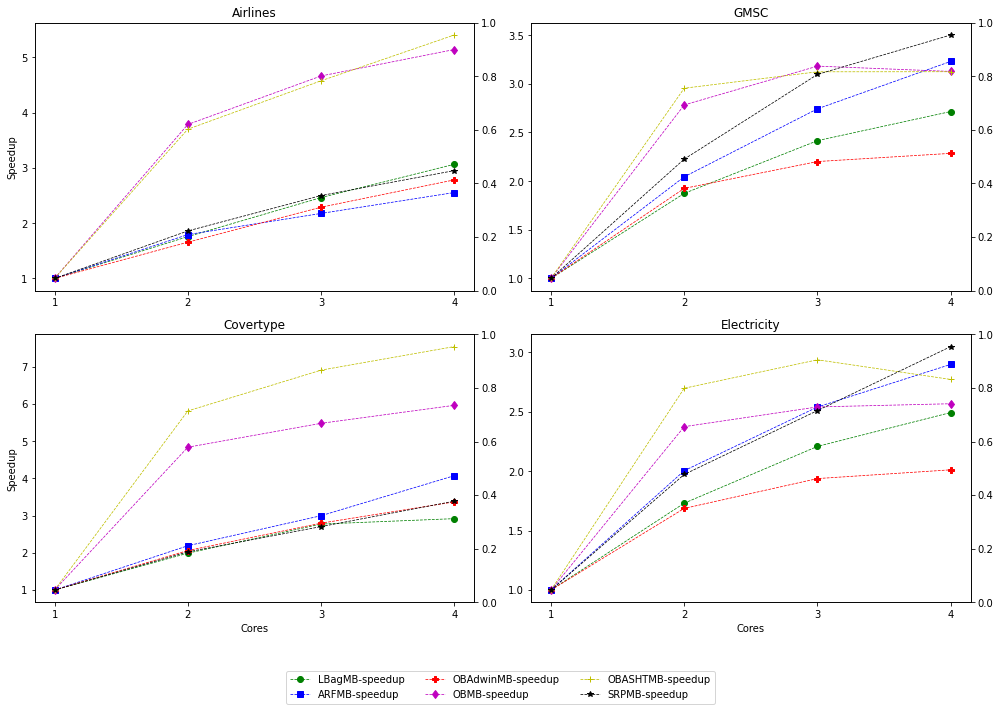

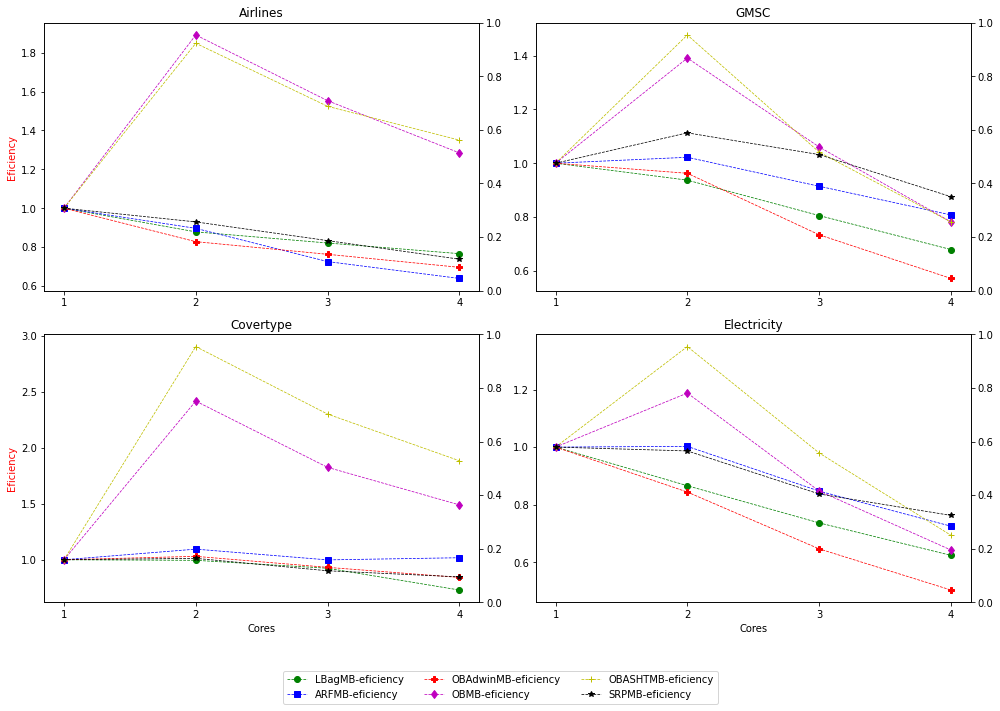

In [234]:
gen_graph_speedup()
gen_graph_speedup(True) # eficiency